In [49]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

data = pd.read_csv("data/investigation_train_large_checked.csv")
print(data.shape)
print(data.info())
print(data.describe(include='all'))


(130000, 318)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130000 entries, 0 to 129999
Columns: 318 entries, adres_aantal_brp_adres to checked
dtypes: bool(1), float64(2), int64(315)
memory usage: 314.5 MB
None
        adres_aantal_brp_adres  adres_aantal_verschillende_wijken  \
count            130000.000000                      130000.000000   
unique                     NaN                                NaN   
top                        NaN                                NaN   
freq                       NaN                                NaN   
mean                  2.880315                           2.095138   
std                   1.475177                           0.927329   
min                   1.000000                           1.000000   
25%                   2.000000                           1.000000   
50%                   3.000000                           2.000000   
75%                   4.000000                           3.000000   
max                  12.0

In [2]:
sensitive_cols = ['persoon_geslacht_vrouw', 'persoon_leeftijd_bij_onderzoek']
for col in sensitive_cols:
    print(f"{col} distribution:\n", data[col].value_counts())


persoon_geslacht_vrouw distribution:
 persoon_geslacht_vrouw
0    66985
1    63015
Name: count, dtype: int64
persoon_leeftijd_bij_onderzoek distribution:
 persoon_leeftijd_bij_onderzoek
51    4857
53    4717
52    4703
50    4699
49    4664
55    4656
54    4576
48    4565
47    4504
56    4422
46    4292
57    4290
58    4207
45    4111
59    4029
44    3890
60    3693
43    3607
61    3547
42    3455
62    3338
41    3222
40    3087
63    3075
39    2828
64    2807
65    2552
38    2537
66    2330
37    2275
36    2097
35    1845
34    1739
33    1508
32    1308
31    1176
30    1023
67     972
29     917
28     740
27     640
26     550
25     478
24     398
23     274
22     262
21     211
20     143
19     132
18      52
Name: count, dtype: int64


<Axes: >

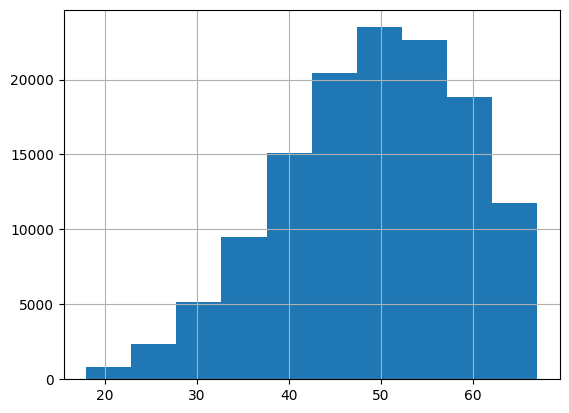

In [50]:
data['persoon_leeftijd_bij_onderzoek'].hist() # age of the person

#### Description of the data

Main fatcs:
- Dataset has 316 variables
- Almost all variables are integers (0/1 flags or counts)

Sensitive columns present include
- persoon_geslacht_vrouw (gender)
- persoon_leeftijd_bij_onderzoek (age)

Ethnicity/nationality variables were removed, but many proxies remain.

### Data analysis and problems with data

#### First problem: Proxy variable for protected attributes

Sensitive attributed are removed from the data because they are legally protected under Dutch anti-discrimination law. Those attributes include:
- Ethnicity / migration background
- Nationality
- Country of birth
- Parents’ country of birth
- Religion
- Neighborhood “ethnic concentration” flags
- Language spoken
- Asylum seeker status
- Detailed immigration reason / status

However they can be derived from other attributes.
For example, attributes for neighbourhood such as:
- adres_recentste_buurt_nieuwe_westen
- adres_recentste_buurt_groot_ijsselmonde
- adres_recentste_buurt_oude_noorden
- adres_recentste_buurt_other 
might act as ethnicity proxies, even though ethnicity itself is removed because Rotterdam neighborhoods strongly correlate with average income, proportion of residents with a migration background, and poverty concentration.

Also, language variables, which can be proxies for ethnicity and race, make up a significant number of the total variables.

This is a data validity issue.

#### Second problem: Sensitive attributes influence predictions too much

Although explicit ethnicity attributes were removed, gender and age remain in the dataset, and many other variables encode family structure (e.g., relatie_kind_volwassen). These attributes can systematically influence the fraud-risk prediction, even though they have no meaningful or causal relationship to welfare fraud.

In practice, this means that certain groups, such as women, especially women with children, may be assigned higher risk scores simply because of their demographic characteristics. This reflects bias in the prediction model, as the presence of these attributes allows the algorithm to treat similar cases differently based on gender or age rather than relevant behavioral indicators.


#### Third problem: Many variables have no meaningful or causal relationship to welfare fraud 

The dataset contains a very large number of administrative flags and neighborhood statistics, such as:
- number of past addresses
- changes in living arrangements
- obstacle_living_situation
These variables do not represent actual fraud behavior. Instead, they reflect poverty, instability in life circumstances, needing social support. This means the model predicts who is poor or struggling, but not who is actually committing fraud.

This is another data validity issue.

#### Fourth issue: Data is skewed/inbalanced

The age distribution shows a clear imbalance (histogram presented before). The vast majority of individuals in the dataset are over 40, while younger people are heavily underrepresented. For example, ages 50–60 each appear around 400–500 times, whereas ages under 30 often occur fewer than 100 times.

This means the dataset is skewed toward older welfare recipients, which can affect model behaviour. A model trained on this distribution will primarily learn patterns from older individuals and may perform poorly on younger people due to limited representation.




### Possible test cases

#### Data partitioning

We will create two types of partitioning. One when we expect the model to have similar results on both partitions and another when we expect to have different results on partitions.

In [51]:
# Data partitioning

target_col = "checked" 

# Partition 1: Expect SAME results

# Split by gender: male vs female (assuming model should not behave differently based on gender)
partition_same_1 = data[data['persoon_geslacht_vrouw'] == 1]
partition_same_2 = data[data['persoon_geslacht_vrouw'] == 0]

# Partition 2: Expect DIFFERENT results

# Split by history of addictions (assuming it is a good criteria for results to be different)
partition_diff_1 = data[data['belemmering_hist_verslavingsproblematiek'] == 1]
partition_diff_2 = data[data['belemmering_hist_verslavingsproblematiek'] == 0]

def test_model_on_partitions(model, partitions, target_col=target_col):
    results = {}
    for i, part in enumerate(partitions):
        X = part.drop(columns=[target_col])
        y = part[target_col]
        preds = model.predict(X)
        results[f"partition_{i+1}"] = {
            "size": len(part),
            "accuracy": (preds == y).mean()
        }
    return results


# Example usage:

# model.fit(data.drop(columns=[target_col]), data[target_col])
# same_results = test_model_on_partitions(model, [partition_same_1, partition_same_2])
# diff_results = test_model_on_partitions(model, [partition_diff_1, partition_diff_2])



In [52]:
# Metamorphic test cases

# Results should not depend on the gender
def metamorphic_gender_swap(model, data, target_col='checked'):
    data_copy = data.copy()
    data_copy['persoon_geslacht_vrouw'] = 1 - data_copy['persoon_geslacht_vrouw']
    X = data_copy.drop(columns=[target_col])
    preds_new = model.predict(X)
    return preds_new


# Small changes in age should not make any difference
def metamorphic_age_shift(model, data, target_col='checked', shift=1):
    data_copy = data.copy()
    data_copy['persoon_leeftijd_bij_onderzoek'] += shift
    X = data_copy.drop(columns=[target_col])
    preds_new = model.predict(X)
    return preds_new


# Swapping districts should not change result (probably, I am not sure about it)
def metamorphic_swap_districts(model, data, target_col='checked'):
    """
    Swap Delfshaven and Feijenoord district indicators.
    """
    data_copy = data.copy()
    
    delf = 'adres_recentste_wijk_delfshaven'  # address_latest_district_delfshaven
    feij = 'adres_recentste_wijk_feijenoord'  # address_latest_district_feijenoord
    
    temp = data_copy[delf].copy()
    data_copy[delf] = data_copy[feij]
    data_copy[feij] = temp
    
    X = data_copy.drop(columns=[target_col])
    preds_new = model.predict(X)
    
    # Compare with original predictions
    # X_orig = data.drop(columns=[target_col])
    # preds_orig = model.predict(X_orig)
    # n_changed = (preds_new != preds_orig).sum()
    # pct_changed = n_changed / len(data) * 100
    # print(f"{n_changed} predictions changed ({pct_changed:.2f}%) after swapping districts")

    return preds_new



PART 3

In [47]:
# bad model

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# define y and X
y = data["checked"].astype(int)
X = data.drop(columns=["checked"])

# also drop these columns
to_drop = ["Ja", "Nee"]
drop_index = [list(X.columns).index(c) for c in to_drop]

# gender column
gender_index = list(X.columns).index("persoon_geslacht_vrouw")

# build ColumnTransformer
# drop columns
# add 10 copies of gender to add bias
bias_ct = ColumnTransformer(
    transformers=[
        ("drop_columns", "drop", drop_index),
        ("gender_bias", "passthrough", [gender_index] * 10),
    ],
    remainder="passthrough"
)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.25, random_state=42
)

# model pipeline
bad_model = Pipeline([
    ("bias", bias_ct),
    ("classifier", GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

# train model
bad_model.fit(X_train, y_train)

# compute model accuracy
predictions = bad_model.predict(X_test)
print("Bad model accuracy:", accuracy_score(y_test, predictions))


Bad model accuracy: 0.9340615384615385


In [48]:
# good model

#  define y and X
y = data["checked"].astype(int)
X = data.drop(columns=["checked"])

# define which columns to drop
to_drop = ["Ja", "Nee"]
sensitive_columns = ["persoon_geslacht_vrouw", "persoon_leeftijd_bij_onderzoek"]

# proxy columns
proxy_prefixes = [
    "adres_recentste_wijk_",
    "adres_recentste_buurt_"
]

proxy_columns = [
    col for col in X.columns 
    if any(col.startswith(prefix) for prefix in proxy_prefixes)
]

# all columns to drop
all_columns_drop = to_drop + sensitive_columns + proxy_columns

print(len(all_columns_drop), "columns were dropped")

# convert names to integer indices (neccesary for ONNX conversion later)
drop_indexes = [list(X.columns).index(c) for c in all_columns_drop]

# ct that drops columns
preprocess_good = ColumnTransformer(
    transformers=[
        ("drop_columns", "drop", drop_indexes),
    ],
    remainder="passthrough"
)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.25, random_state=42
)

# model pipeline
good_model = Pipeline([
    ("preprocess", preprocess_good),
    ("clf", GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=1,
        random_state=42
    ))
])

# train model
good_model.fit(X_train, y_train)

# compute model accuracy
predictions_good = good_model.predict(X_test)
print("Good model accuracy:", accuracy_score(y_test, predictions_good))


18 columns were dropped
Good model accuracy: 0.8577230769230769


In [51]:
# partition tests

print("\nbad model")
bad_same_results = test_model_on_partitions(bad_model, [partition_same_1, partition_same_2])
bad_diff_results = test_model_on_partitions(bad_model, [partition_diff_1, partition_diff_2])
print("Expect SAME results (gender):", bad_same_results)
print("Expect DIFFERENT results (addiction):", bad_diff_results)

print("\ngood model")
good_same_results = test_model_on_partitions(good_model, [partition_same_1, partition_same_2])
good_diff_results = test_model_on_partitions(good_model, [partition_diff_1, partition_diff_2])
print("Expect SAME results (gender):", good_same_results)
print("Expect DIFFERENT results (addiction):", good_diff_results)



bad model
Expect SAME results (gender): {'partition_1': {'size': 63015, 'accuracy': np.float64(0.9347456954693327)}, 'partition_2': {'size': 66985, 'accuracy': np.float64(0.940210494886915)}}
Expect DIFFERENT results (addiction): {'partition_1': {'size': 7838, 'accuracy': np.float64(0.9163051798928298)}, 'partition_2': {'size': 122162, 'accuracy': np.float64(0.938925361405347)}}

good model
Expect SAME results (gender): {'partition_1': {'size': 63015, 'accuracy': np.float64(0.8612711259223994)}, 'partition_2': {'size': 66985, 'accuracy': np.float64(0.8588639247592744)}}
Expect DIFFERENT results (addiction): {'partition_1': {'size': 7838, 'accuracy': np.float64(0.824189844348048)}, 'partition_2': {'size': 122162, 'accuracy': np.float64(0.862330348226126)}}


In [53]:
# metamorphic tests

# original predictions
X_full = data.drop(columns=["checked"])
orig_bad = bad_model.predict(X_full)
orig_good = good_model.predict(X_full)

# gender swap
bad_gender_swapped = metamorphic_gender_swap(bad_model, data)
good_gender_swapped = metamorphic_gender_swap(good_model, data)

print("\nGENDER SWAP TEST")
print("Bad model change rate:", (bad_gender_swapped != orig_bad).mean())
print("Good model change rate:", (good_gender_swapped != orig_good).mean())

# age shift
bad_age_shift = metamorphic_age_shift(bad_model, data)
good_age_shift = metamorphic_age_shift(good_model, data)

print("\nAGE SHIFT TEST")
print("Bad model change rate:", (bad_age_shift != orig_bad).mean())
print("Good model change rate:", (good_age_shift != orig_good).mean())

# district swap
bad_dist = metamorphic_swap_districts(bad_model, data)
good_dist = metamorphic_swap_districts(good_model, data)

print("\nDISTRICT SWAP TEST")
print("Bad model change rate:", (bad_dist != orig_bad).mean())
print("Good model change rate:", (good_dist != orig_good).mean())



GENDER SWAP TEST
Bad model change rate: 0.0007923076923076923
Good model change rate: 0.0

AGE SHIFT TEST
Bad model change rate: 0.012376923076923077
Good model change rate: 0.0

DISTRICT SWAP TEST
Bad model change rate: 0.0
Good model change rate: 0.0


In [55]:
# export models to ONNX

import onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import os

os.makedirs("models", exist_ok=True)

# assign models
pipeline1 = bad_model
pipeline2 = good_model

print("model_1 = bad model")
print("model_2 = good model")

# convert bad model to ONNX
onnx_model1 = convert_sklearn(
    pipeline1, initial_types=[('X', FloatTensorType([None, X_train.shape[1]]))],
    target_opset=12
)
onnx.save(onnx_model1, "models/model_1.onnx")

# convert good model to ONNX
onnx_model2 = convert_sklearn(
    pipeline2, initial_types=[('X', FloatTensorType([None, X_train.shape[1]]))],
    target_opset=12
)
onnx.save(onnx_model2, "models/model_2.onnx")

print("ONNX models are saved")


model_1 = bad model
model_2 = good model
ONNX models are saved


#### Testing models of another subgroup

In [53]:
import onnxruntime as ort
import numpy as np

class ONNXModelWrapper:
    def __init__(self, path):
        self.session = ort.InferenceSession(path)
        self.input_name = self.session.get_inputs()[0].name

    def predict(self, X):
        if hasattr(X, "values"):
            X = X.values.astype(np.float32)
        else:
            X = X.astype(np.float32)

        outputs = self.session.run(None, {self.input_name: X})
        preds = outputs[0]

        # convert to binary
        if preds.ndim > 1 and preds.shape[1] == 2:
            preds = np.argmax(preds, axis=1)
        elif preds.ndim > 1:
            preds = preds[:, 0]

        return (preds > 0.5).astype(int)


In [54]:
testing_model_1 = ONNXModelWrapper("models_to_test/model_1.onnx")
testing_model_2 = ONNXModelWrapper("models_to_test/model_2.onnx")

In [55]:
data_big = pd.read_csv("data/investigation_train_large_checked.csv")
print(data_big.shape)

data_small = pd.read_csv("data/synth_data_for_training.csv")
print(data_small.shape)

(130000, 318)
(12645, 316)


In [ ]:
data = data_big
print(data_big.shape)

(130000, 318)


In [57]:
# metamorphic tests

# original predictions
data_full = data.drop(columns=["checked"]).drop(columns=["Ja"]).drop(columns=["Nee"])
data_prepped = data.drop(columns=["Ja"]).drop(columns=["Nee"])


orig_1 = testing_model_1.predict(data_full)
orig_2 = testing_model_2.predict(data_full)

# gender swap
gender_swapped_1 = metamorphic_gender_swap(testing_model_1, data_prepped)
gender_swapped_2 = metamorphic_gender_swap(testing_model_2, data_prepped)

print("\nGENDER SWAP TEST")
print("First model change rate:", (gender_swapped_1 != orig_1).mean())
print("Second model change rate:", (gender_swapped_2 != orig_2).mean())

# age shift
age_shift_1 = metamorphic_age_shift(testing_model_1, data_prepped)
age_shift_2 = metamorphic_age_shift(testing_model_2, data_prepped)

print("\nAGE SHIFT TEST")
print("First model change rate:", (age_shift_1 != orig_1).mean())
print("Second model change rate:", (age_shift_2 != orig_2).mean())

# district swap
dist_1 = metamorphic_swap_districts(testing_model_1, data_prepped)
dist_2 = metamorphic_swap_districts(testing_model_2, data_prepped)

print("\nDISTRICT SWAP TEST")
print("First model change rate:", (dist_1 != orig_1).mean())
print("Second model change rate:", (dist_2 != orig_2).mean())



GENDER SWAP TEST
First model change rate: 0.02103076923076923
Second model change rate: 0.0004307692307692308

AGE SHIFT TEST
First model change rate: 0.013507692307692307
Second model change rate: 0.0005846153846153846

DISTRICT SWAP TEST
First model change rate: 0.0
Second model change rate: 0.00020769230769230768


In [58]:
# partition tests

# Partition 1: Expect SAME results

# Split by gender: male vs female (assuming model should not behave differently based on gender)
partition_same_1 = data_prepped[data_prepped['persoon_geslacht_vrouw'] == 1]
partition_same_2 = data_prepped[data_prepped['persoon_geslacht_vrouw'] == 0]

# Partition 2: Expect DIFFERENT results

# Split by history of addictions (assuming it is a good criteria for results to be different)
partition_diff_1 = data_prepped[data_prepped['belemmering_hist_verslavingsproblematiek'] == 1]
partition_diff_2 = data_prepped[data_prepped['belemmering_hist_verslavingsproblematiek'] == 0]

print("\First model")
bad_same_results = test_model_on_partitions(testing_model_1, [partition_same_1, partition_same_2])
bad_diff_results = test_model_on_partitions(testing_model_1, [partition_diff_1, partition_diff_2])
print("Expect SAME results (gender):", bad_same_results)
print("Expect DIFFERENT results (addiction):", bad_diff_results)

print("\Second model")
good_same_results = test_model_on_partitions(testing_model_2, [partition_same_1, partition_same_2])
good_diff_results = test_model_on_partitions(testing_model_2, [partition_diff_1, partition_diff_2])
print("Expect SAME results (gender):", good_same_results)
print("Expect DIFFERENT results (addiction):", good_diff_results)


\First model
Expect SAME results (gender): {'partition_1': {'size': 63015, 'accuracy': 0.9483297627548997}, 'partition_2': {'size': 66985, 'accuracy': 0.9473314921251026}}
Expect DIFFERENT results (addiction): {'partition_1': {'size': 7838, 'accuracy': 0.9365909670834397}, 'partition_2': {'size': 122162, 'accuracy': 0.9485355511533865}}
\Second model
Expect SAME results (gender): {'partition_1': {'size': 63015, 'accuracy': 0.9687852098706657}, 'partition_2': {'size': 66985, 'accuracy': 0.969575278047324}}
Expect DIFFERENT results (addiction): {'partition_1': {'size': 7838, 'accuracy': 0.9607042612911457}, 'partition_2': {'size': 122162, 'accuracy': 0.9697369067304071}}
